In [232]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
from tqdm import tqdm
import os
import sys
sys.path.insert(0, os.path.abspath('../div_measures/amp/src'))
from modules import GaussianDiag, EP, MMSE, PowerEP, StochasticEP, ExpansionEP, ExpansionPowerEP, ExpectationConsistency, LoopyBP, LoopyMP, PPBP, AlphaBP, MMSEalphaBP, ML, VariationalBP, MMSEvarBP, EPalphaBP
from utils import channel_component, sampling_noise, sampling_signal, sampling_H,real2complex
import seaborn as sns

In [11]:
mu, sigma = 0, 0.5
s = np.array([])
for i in range(10):
    s = np.append(s,np.random.normal(mu, sigma, 1000))

In [12]:
def univariate_normal(x, mean, variance):
    """pdf of the univariate normal distribution."""
    return ((1. / np.sqrt(2 * np.pi * variance)) * 
            np.exp(-(x - mean)**2 / (2 * variance)))

In [123]:
def mutipleUnivarianteNormal(amount, means, variances, x):
    value = 0
    for i in range(amount):
        value += univariate_normal(x, means[i], variances[i])
    return value / ( amount * 2) 

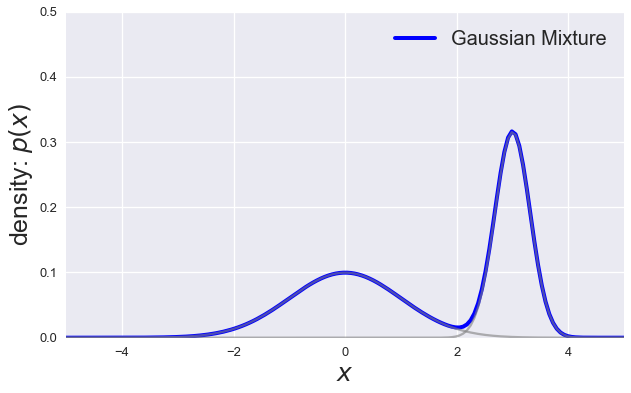

In [231]:
AMOUNT = 2
MEANS = [0,3]
VARIANCES = [1,0.1]

x = np.linspace(-5, 5, num=150)
fig, ax = plt.subplots(figsize=(10, 6))
#fig = plt.figure(figsize=(10, 6))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.style.use('seaborn-talk')
plt.plot(
    x, mutipleUnivarianteNormal(AMOUNT, MEANS, VARIANCES, x), 
    label="Gaussian Mixture", color = 'blue', linewidth=4)
for i in range(AMOUNT): 
    plt.plot(x, univariate_normal(x, MEANS[i] , VARIANCES[i]) / 4, color = 'grey', alpha=0.6)
plt.xlabel('$x$', fontsize=25)
plt.ylabel('density: $p(x)$', fontsize=25)
plt.ylim([0, 0.5])
plt.xlim([-5, 5])
plt.legend(loc=1, fontsize=20)
#fig.subplots_adjust(bottom=0.15)
plt.show()

In [76]:
def kl_divergence(p, q): 
    return np.sum(p*np.log(p/q))

In [164]:
# configuration of experiments
class hparam(object):
    # vector length of x = num_tx *2, section 1 in amp.pdf
    num_tx = 200
    # vector length of y = num_rx *2, section 1 in amp.pdf
    num_rx = 100
    # the finite set A, section 1 in amp.pdf
    constellation = np.arange(-50,50) 
    prior_lin = np.linspace(-5, 5, num=100)
    priors_unnormalized = mutipleUnivarianteNormal(AMOUNT, MEANS, VARIANCES, prior_lin)
    priors_normalized = priors_unnormalized / np.sum(priors_unnormalized)
    soucrce_prior = priors_normalized #[0.25, 0.25, 0.25, 0.25]
    signal_var = 1
    snr = np.linspace(1,100, 10)
    # number of monte carlo simulations per point in the experiment figure
    monte = 1
    # power_n is the coefficient for power EP
    power_n = 2
    # update dumping parameter for EC algorithm
    EC_beta = 0.2
    
    alpha = 0.8
    # a dictionary of algorithms to be tested in the experiment
    algos = {
             "PowerEP": {"detector": PowerEP, "legend": "Power EP"},
             "EP": {"detector": EP, "legend": "EP"},
             #"EPalphaBP": {"detector": EPalphaBP, "legend": r'$\alpha$-BP+EP,'+' {}'.format(alpha)},
             #"AlphaBP": {"detector": AlphaBP, "legend":r'$\alpha$-BP, 0.2'},
            }

    for _, value in algos.items():
        value["ser"] = []



In [233]:
def task(snr):
    '''
    Given the snr value, do the experiment with setting defined in hparam
    '''
    tmp = dict()
    temp2 = dict()
    for name,_ in hparam.algos.items():
        tmp[name] = []
        temp2[name] = []

    #progress = tqdm(range(hparam.monte))
    for monte in tqdm(range(hparam.monte)):
        x, true_symbol = sampling_signal(hparam)
        #noise variance in control by SNR in DB
        noise, noise_var = sampling_noise(hparam=hparam, snr=snr)
        channel = sampling_H(hparam)
        noised_signal = np.dot(channel,x) # + noise
        #print("before",x)
        for key, method in hparam.algos.items():
            detector = method['detector'](noise_var, hparam)
            detector.fit(channel=channel,
                         noise_var=noise_var,
                         noised_signal=noised_signal,
                         stop_iter=10)


            estimated_symbol = detector.detect_signal_by_mean()

            est_complex_symbol = real2complex(estimated_symbol)
            # error = np.sum(x != estimated_symbol)
            #print("le symbol", estimated_symbol)
            error = np.sum(abs(x - estimated_symbol))
            
            tmp[key].append(error)
            temp2[key].append((np.array(x), np.array(estimated_symbol)))
    performance = {"snr": snr}
    dists = {}
    for key, method in hparam.algos.items():
        #method["ser"].append( np.mean(tmp[key])/hparam.num_tx )
        performance[key] =  np.mean(np.array(tmp[key]))/hparam.num_tx
        dists[key] = temp2[key]
 
    return performance, dists

In [234]:
perf, dist = task(10e2)

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


In [235]:
mu, std = norm.fit(dist['EP'][0][1] / 10)

Text(0.5, 1.0, 'EP for KL-Divergence or alpha = 1: mu = 0.77,  std = 1.34')

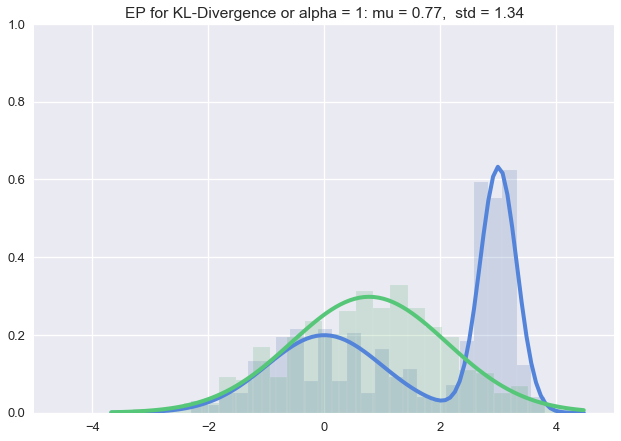

In [238]:
plt.hist(dist['EP'][0][0] / 10, bins=25, density=True, alpha=0.2)
plt.hist(dist['EP'][0][1] / 10, bins=25, density=True, alpha=0.2)
# Plot the PDF.
plt.style.use('seaborn-talk')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(
    x, mutipleUnivarianteNormal(AMOUNT, MEANS, VARIANCES, x) * 2,
    color='#5484da', linewidth=4)
plt.plot(x, p, 'k', linewidth=4, color='#56c778')
plt.ylim([0, 1])
plt.xlim([-5, 5])
title = "EP for KL-Divergence or alpha = 1: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

In [ ]:
"""
From here the alpha stuff comes
"""

In [63]:
class hparam(object):
    # vector length of x = num_tx *2, section 1 in amp.pdf
    num_tx = 10
    # vector length of y = num_rx *2, section 1 in amp.pdf
    num_rx = 10
    # the finite set A, section 1 in amp.pdf
    constellation = np.arange(-10,10) #[int(-2), int(-1), int(1), int(2)]
    prior_lin = np.linspace(-5, 5, num=20)
    priors_unnormalized = mutipleUnivarianteNormal(AMOUNT, MEANS, VARIANCES, prior_lin)
    priors_normalized = priors_unnormalized / np.sum(priors_unnormalized)
    soucrce_prior = priors_normalized #[0.25, 0.25, 0.25, 0.25]
    signal_var = 1
    snr = np.linspace(1, 40, 10)
    # number of monte carlo simulations per point in the experiment figure
    monte = 5
    power_n = 2
    # update dumping parameter for EC algorithm
    EC_beta = 0.2
    alpha = 1
    ############## observer effect of Alpha for linear system  ########
    algos = {
             "AlphaBP, 0.2": {"detector": AlphaBP, "alpha": 1, "legend":r'$\alpha$-BP, 0.2'},
             #"AlphaBP, 0.4": {"detector": AlphaBP, "alpha": 0.4, "legend":r'$\alpha$-BP, 0.4'},
             #"AlphaBP, 0.8": {"detector": AlphaBP, "alpha": 0.6, "legend":r'$\alpha$-BP, 0.6'},
             #"AlphaBP, 1.2": {"detector": AlphaBP, "alpha": 0.8, "legend":r'$\alpha$-BP, 0.8'},
             "EPalphaBP, 0.2": {"detector": EPalphaBP, "alpha": 1, "legend": r'$\alpha$-BP+EP,'+' {}'.format(alpha)}
    }
    
    iter_num = {
                "AlphaBP": 10,
                "EPalphaBP": 10
    }
    
    for _, value in algos.items():
        value["ser"] = []


In [64]:
def task2(snr):
    '''
    Given the snr value, do the experiment with setting defined in hparam
    '''
    tmp = dict()
    for name,_ in hparam.algos.items():
        tmp[name] = []


    for monte in tqdm(range(hparam.monte)):
        x, true_symbol = sampling_signal(hparam)
        #noise variance in control by SNR in DB
        noise, noise_var = sampling_noise(hparam=hparam, snr=snr)
        channel = sampling_H(hparam)
        noised_signal = np.dot(channel,x) + noise
        for key, method in hparam.algos.items():
            if key is "MMSE" or key is "ML":
                #### mes detection
                detector = method["detector"](hparam)
                power_ratio = noise_var/hparam.signal_var
                estimated_symbol = detector.detect(y=noised_signal, channel=channel, power_ratio=power_ratio)
                #estimated_symbol = real2complex(np.sign(detected_by_mmse))
            else:
                if "Alpha" in key or "alpha" in key:
                    hparam.alpha = method['alpha']

                detector = method['detector'](noise_var, hparam)
                detector.fit(channel=channel,
                             noise_var=noise_var,
                             noised_signal=noised_signal,
                             stop_iter=10)
                
                        
                estimated_symbol = detector.detect_signal_by_mean()


            est_complex_symbol = real2complex(estimated_symbol)
            print("symbols", x, true_symbol, est_complex_symbol)
            # error = np.sum(true_symbol != est_complex_symbol)
            error = np.sum(abs(x - estimated_symbol))
            
            tmp[key].append(error)

    performance = {"snr": snr}
    for key, method in hparam.algos.items():
        #method["ser"].append( np.mean(tmp[key])/hparam.num_tx )
        performance[key] =  np.mean(np.array(tmp[key]))/hparam.num_tx
 
    return performance

<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-64-f328b94a3741>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if key is "MMSE" or key is "ML":
<ipython-input-64-f328b94a3741>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if key is "MMSE" or key is "ML":


In [65]:
task2(1e2)

  0%|          | 0/5 [00:00<?, ?it/s]

symbols [ 2 -4 -2  5  2  1 -5  6 -4 -7 -4  1 -1 -6  5 -2  5  0 -3  2] [ 2.-4.j -4.+1.j -2.-1.j  5.-6.j  2.+5.j  1.-2.j -5.+5.j  6.+0.j -4.-3.j
 -7.+2.j] [-10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j
 -10.-10.j -10.-10.j -10.-10.j]


 20%|██        | 1/5 [00:00<00:03,  1.19it/s]

symbols [ 2 -4 -2  5  2  1 -5  6 -4 -7 -4  1 -1 -6  5 -2  5  0 -3  2] [ 2.-4.j -4.+1.j -2.-1.j  5.-6.j  2.+5.j  1.-2.j -5.+5.j  6.+0.j -4.-3.j
 -7.+2.j] [-10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j
 -10.-10.j -10.-10.j -10.-10.j]
symbols [ 6 -1 -5  5 -3 -2 -1  1 -3  0  5  0 -4  2  2  0  0 -3 -6 -3] [ 6.+5.j -1.+0.j -5.-4.j  5.+2.j -3.+2.j -2.+0.j -1.+0.j  1.-3.j -3.-6.j
  0.-3.j] [-10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j
 -10.-10.j -10.-10.j -10.-10.j]


 40%|████      | 2/5 [00:01<00:02,  1.20it/s]

symbols [ 6 -1 -5  5 -3 -2 -1  1 -3  0  5  0 -4  2  2  0  0 -3 -6 -3] [ 6.+5.j -1.+0.j -5.-4.j  5.+2.j -3.+2.j -2.+0.j -1.+0.j  1.-3.j -3.-6.j
  0.-3.j] [-10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j
 -10.-10.j -10.-10.j -10.-10.j]
symbols [-2 -7 -5  5  2 -2 -4  0 -2 -1  5  3 -1  1  6 -2  1 -3 -5  6] [-2.+5.j -7.+3.j -5.-1.j  5.+1.j  2.+6.j -2.-2.j -4.+1.j  0.-3.j -2.-5.j
 -1.+6.j] [-10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j
 -10.-10.j -10.-10.j -10.-10.j]


 60%|██████    | 3/5 [00:02<00:01,  1.21it/s]

symbols [-2 -7 -5  5  2 -2 -4  0 -2 -1  5  3 -1  1  6 -2  1 -3 -5  6] [-2.+5.j -7.+3.j -5.-1.j  5.+1.j  2.+6.j -2.-2.j -4.+1.j  0.-3.j -2.-5.j
 -1.+6.j] [-10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j
 -10.-10.j -10.-10.j -10.-10.j]
symbols [ 2 -4 -2  3  5  1  5  0  5 -4 -1  4  5 -4 -5  5  1 -3 -4 -5] [ 2.-1.j -4.+4.j -2.+5.j  3.-4.j  5.-5.j  1.+5.j  5.+1.j  0.-3.j  5.-4.j
 -4.-5.j] [-10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j
 -10.-10.j -10.-10.j -10.-10.j]


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

symbols [ 2 -4 -2  3  5  1  5  0  5 -4 -1  4  5 -4 -5  5  1 -3 -4 -5] [ 2.-1.j -4.+4.j -2.+5.j  3.-4.j  5.-5.j  1.+5.j  5.+1.j  0.-3.j  5.-4.j
 -4.-5.j] [-10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j
 -10.-10.j -10.-10.j -10.-10.j]
symbols [-1 -6  2  3  3  6 -4  5 -3  0 -4  1  3  4 -1  5  1  5  6  5] [-1.-4.j -6.+1.j  2.+3.j  3.+4.j  3.-1.j  6.+5.j -4.+1.j  5.+5.j -3.+6.j
  0.+5.j] [-10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j
 -10.-10.j -10.-10.j -10.-10.j]


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]

symbols [-1 -6  2  3  3  6 -4  5 -3  0 -4  1  3  4 -1  5  1  5  6  5] [-1.-4.j -6.+1.j  2.+3.j  3.+4.j  3.-1.j  6.+5.j -4.+1.j  5.+5.j -3.+6.j
  0.+5.j] [-10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j -10.-10.j
 -10.-10.j -10.-10.j -10.-10.j]


{'snr': 100.0, 'AlphaBP, 0.2': 20.2, 'EPalphaBP, 0.2': 20.2}

In [135]:
class hparam(object):
    # vector length of x = num_tx *2, section 1 in amp.pdf
    num_tx = 4
    # vector length of y = num_rx *2, section 1 in amp.pdf
    num_rx = 4
    # the finite set A, section 1 in amp.pdf
    constellation = [int(-1), int(1)]
    soucrce_prior = [0.5, 0.5]
    signal_var = 1
    snr = np.linspace(1, 40, 10)
    # number of monte carlo simulations per point in the experiment figure
    monte = 5
    power_n = 4./3
    # update dumping parameter for EC algorithm
    EC_beta = 0.2
    alpha = None
    ############## observer effect of Alpha for linear system  ########
    algos = {"MMSE": {"detector": MMSE, "legend": "MMSE"},
             "ML": {"detector": ML, "legend": "MAP"},
             "LoopyBP": {"detector": LoopyBP, "legend": "BP"},
             "AlphaBP, 0.2": {"detector": AlphaBP, "alpha": 0.2, "legend":r'$\alpha$-BP, 0.2'},
             "AlphaBP, 0.4": {"detector": AlphaBP, "alpha": 0.4, "legend":r'$\alpha$-BP, 0.4'},
             "AlphaBP, 0.8": {"detector": AlphaBP, "alpha": 0.6, "legend":r'$\alpha$-BP, 0.6'},
             "AlphaBP, 1.2": {"detector": AlphaBP, "alpha": 0.8, "legend":r'$\alpha$-BP, 0.8'}
    }
    
    iter_num = {"EP": 10,
                "EC": 50,
                "LoopyBP": 50,
                "PPBP": 50,
                "AlphaBP": 50,
                "MMSEalphaBP": 50,
                "VariationalBP":50,
                "EPalphaBP": 50,
                "MMSEvarBP":50,
                "LoopyMP": 50}
    
    for _, value in algos.items():
        value["ser"] = []




def task3(snr):
    '''
    Given the snr value, do the experiment with setting defined in hparam
    '''
    tmp = dict()
    for name,_ in hparam.algos.items():
        tmp[name] = []


    for monte in tqdm(range(hparam.monte)):
        x, true_symbol = sampling_signal(hparam)
        #noise variance in control by SNR in DB
        noise, noise_var = sampling_noise(hparam=hparam, snr=snr)
        channel = sampling_H(hparam)
        noised_signal = np.dot(channel,x) + noise
        for key, method in hparam.algos.items():
            if key is "MMSE" or key is "ML":
                #### mes detection
                detector = method["detector"](hparam)
                power_ratio = noise_var/hparam.signal_var
                estimated_symbol = detector.detect(y=noised_signal, channel=channel, power_ratio=power_ratio)
                #estimated_symbol = real2complex(np.sign(detected_by_mmse))
            else:
                if "Alpha" in key or "alpha" in key:
                    hparam.alpha = method['alpha']

                detector = method['detector'](noise_var, hparam)
                detector.fit(channel=channel,
                             noise_var=noise_var,
                             noised_signal=noised_signal,
                             stop_iter=50)
                
                        
                estimated_symbol = detector.detect_signal_by_mean()

            est_complex_symbol = real2complex(estimated_symbol)
            error = np.sum(true_symbol != est_complex_symbol)
            print(x, true_symbol, estimated_symbol)
            
            tmp[key].append(error)

    performance = {"snr": snr}
    for key, method in hparam.algos.items():
        #method["ser"].append( np.mean(tmp[key])/hparam.num_tx )
        performance[key] =  np.mean(np.array(tmp[key]))/hparam.num_tx
 
    return performance

<>:60: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:60: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:60: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:60: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-135-147ed4b67892>:60: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if key is "MMSE" or key is "ML":
<ipython-input-135-147ed4b67892>:60: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if key is "MMSE" or key is "ML":


In [136]:
task3(1e3)

  0%|          | 0/5 [00:00<?, ?it/s]

[-1 -1 -1  1 -1 -1  1 -1] [-1.-1.j -1.-1.j -1.+1.j  1.-1.j] [-1 -1 -1  1 -1 -1  1 -1]
[-1 -1 -1  1 -1 -1  1 -1] [-1.-1.j -1.-1.j -1.+1.j  1.-1.j] (-1, -1, -1, 1, -1, -1, 1, -1)
[-1 -1 -1  1 -1 -1  1 -1] [-1.-1.j -1.-1.j -1.+1.j  1.-1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[-1 -1 -1  1 -1 -1  1 -1] [-1.-1.j -1.-1.j -1.+1.j  1.-1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[-1 -1 -1  1 -1 -1  1 -1]

 20%|██        | 1/5 [00:00<00:01,  2.85it/s]

 [-1.-1.j -1.-1.j -1.+1.j  1.-1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[-1 -1 -1  1 -1 -1  1 -1] [-1.-1.j -1.-1.j -1.+1.j  1.-1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[-1 -1 -1  1 -1 -1  1 -1] [-1.-1.j -1.-1.j -1.+1.j  1.-1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[-1  1 -1 -1  1  1 -1  1] [-1.+1.j  1.+1.j -1.-1.j -1.+1.j] [-1  1 -1 -1  1  1 -1  1]
[-1  1 -1 -1  1  1 -1  1] [-1.+1.j  1.+1.j -1.-1.j -1.+1.j] (-1, 1, -1, -1, 1, 1, -1, 1)
[-1  1 -1 -1  1  1 -1  1] [-1.+1.j  1.+1.j -1.-1.j -1.+1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[-1  1 -1 -1  1  1 -1  1] [-1.+1.j  1.+1.j -1.-1.j -1.+1.j] [-1, 1, -1, -1, 1, 1, -1, 1]


 40%|████      | 2/5 [00:00<00:01,  2.77it/s]

[-1  1 -1 -1  1  1 -1  1] [-1.+1.j  1.+1.j -1.-1.j -1.+1.j] [-1, 1, -1, -1, 1, 1, -1, 1]
[-1  1 -1 -1  1  1 -1  1] [-1.+1.j  1.+1.j -1.-1.j -1.+1.j] [-1, 1, -1, -1, 1, 1, -1, 1]
[-1  1 -1 -1  1  1 -1  1] [-1.+1.j  1.+1.j -1.-1.j -1.+1.j] [-1, 1, -1, -1, 1, 1, -1, 1]
[ 1 -1  1  1  1 -1  1  1] [ 1.+1.j -1.-1.j  1.+1.j  1.+1.j] [ 1 -1  1  1  1 -1  1  1]
[ 1 -1  1  1  1 -1  1  1] [ 1.+1.j -1.-1.j  1.+1.j  1.+1.j] (1, -1, 1, 1, 1, -1, 1, 1)
[ 1 -1  1  1  1 -1  1  1] [ 1.+1.j -1.-1.j  1.+1.j  1.+1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[ 1 -1  1  1  1 -1  1  1]

 60%|██████    | 3/5 [00:01<00:00,  2.80it/s]

 [ 1.+1.j -1.-1.j  1.+1.j  1.+1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[ 1 -1  1  1  1 -1  1  1] [ 1.+1.j -1.-1.j  1.+1.j  1.+1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[ 1 -1  1  1  1 -1  1  1] [ 1.+1.j -1.-1.j  1.+1.j  1.+1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[ 1 -1  1  1  1 -1  1  1] [ 1.+1.j -1.-1.j  1.+1.j  1.+1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[-1 -1 -1 -1  1 -1  1 -1] [-1.+1.j -1.-1.j -1.+1.j -1.-1.j] [-1 -1 -1 -1  1 -1  1 -1]
[-1 -1 -1 -1  1 -1  1 -1] [-1.+1.j -1.-1.j -1.+1.j -1.-1.j] (-1, -1, -1, -1, 1, -1, 1, -1)
[-1 -1 -1 -1  1 -1  1 -1] [-1.+1.j -1.-1.j -1.+1.j -1.-1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[-1 -1 -1 -1  1 -1  1 -1] [-1.+1.j -1.-1.j -1.+1.j -1.-1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[-1 -1 -1 -1  1 -1  1 -1]

 80%|████████  | 4/5 [00:01<00:00,  2.83it/s]

 [-1.+1.j -1.-1.j -1.+1.j -1.-1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[-1 -1 -1 -1  1 -1  1 -1] [-1.+1.j -1.-1.j -1.+1.j -1.-1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[-1 -1 -1 -1  1 -1  1 -1] [-1.+1.j -1.-1.j -1.+1.j -1.-1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[ 1 -1  1 -1  1 -1 -1 -1] [ 1.+1.j -1.-1.j  1.-1.j -1.-1.j] [ 1 -1  1 -1  1 -1 -1 -1]
[ 1 -1  1 -1  1 -1 -1 -1] [ 1.+1.j -1.-1.j  1.-1.j -1.-1.j] (1, -1, 1, -1, 1, -1, -1, -1)
[ 1 -1  1 -1  1 -1 -1 -1] [ 1.+1.j -1.-1.j  1.-1.j -1.-1.j] [-1, -1, -1, -1, -1, -1, -1, -1]


100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

[ 1 -1  1 -1  1 -1 -1 -1] [ 1.+1.j -1.-1.j  1.-1.j -1.-1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[ 1 -1  1 -1  1 -1 -1 -1] [ 1.+1.j -1.-1.j  1.-1.j -1.-1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[ 1 -1  1 -1  1 -1 -1 -1] [ 1.+1.j -1.-1.j  1.-1.j -1.-1.j] [-1, -1, -1, -1, -1, -1, -1, -1]
[ 1 -1  1 -1  1 -1 -1 -1] [ 1.+1.j -1.-1.j  1.-1.j -1.-1.j] [-1, -1, -1, -1, -1, -1, -1, -1]


{'snr': 1000.0,
 'MMSE': 0.0,
 'ML': 0.0,
 'LoopyBP': 0.6,
 'AlphaBP, 0.2': 0.45,
 'AlphaBP, 0.4': 0.45,
 'AlphaBP, 0.8': 0.45,
 'AlphaBP, 1.2': 0.45}